In [415]:
import numpy as np
import math
import concurrent.futures 

In [416]:
def generate_microstates(n):
    states = [list(format(i, f'0{n}b')) for i in range(2**n)]
    return {tuple(map(int, state)) for state in states}
    #return states

In [417]:
S_REF = 1.2
T_REF = 298
SIGMA = 0.001
R = 8.314
LO_THRESH = 2
HI_THRESH = 13

def get_s_temp(temp, s_ref=S_REF):
    s = math.pow(s_ref, (T_REF/temp))
    return s

def calc_penalty(state, s_temp):
    state = [1 if int(i) == 1 else 0 for i in state]
    nhelix = np.sum(state)
    return SIGMA * math.pow(s_temp, nhelix)

def compute_free_energy(state, temp):
    s_temp = get_s_temp(temp)
    penalty = calc_penalty(state, s_temp)
    energy = -R*temp*math.log(penalty)
    return energy

In [418]:
def metropolis_criterion(dE, T=298):
    R = 8.314
    if dE > 0:
        w=np.exp(-dE/(R*T))
    else:
        w=1
    return w

In [419]:
from Levenshtein import distance 

def get_key(state):
    return ''.join([str(i) for i in state])

def generate_ssa_seqs(nres):
    seqs = []

    for start in range(nres):
        for end in range(nres):
            seq = [0]*nres
            if start <= end:
                seq[start:end+1] = [1]*(end-start+1)
            seq = ''.join([str(i) for i in seq])
            seqs.append(seq)
    return list(set(seqs))

def get_distance(seq1, seq2):
    dist = distance(seq1, seq2)
    return dist

def neighbours(seq, total_seqs):
    nlist = []
    for i in total_seqs:
        if get_distance(seq, i) == 1:
            temp = list(i)
            temp = [int(i) for i in temp]
            nlist.append(temp)
    return nlist

def generate_neighbour_list(total_seqs):
    neighbour_dict = {}
    for i in total_seqs:
        neighbour_dict[i] = neighbours(i, total_seqs)
    return neighbour_dict

In [420]:
def get_route(routes):
    route = []
    for i in routes:
        if i not in route:
            route.append(i)
    return route


In [ ]:
def monte_carlo_folding(n, steps=100000, temp = 298):
    # microstates = generate_microstates(n)
    microstates = generate_ssa_seqs(n)
    neighbour_dict = generate_neighbour_list(microstates)
    state_energy = {state: compute_free_energy(state, temp) for state in microstates}
    # print('state_energy', state_energy)
    start_state = ''.join(['0']*n)
    # print('start state', start_state)
    # print(microstates)
    macrostates = []
    routes = []
    current_state = start_state
    for i in range(steps):
        #print(i)
        path = []
        if current_state != '1'*n:
           # print(state)
            #neighbors = get_neighbors(state, microstates)
            #if not neighbors:
             #   break
            #print(current_state)
            accessibles = neighbour_dict[get_key(current_state)]
            # print(accessibles)
            for state in accessibles:
                #chosen_state = min(neighbors, key=lambda s: state_energy[s])
                next_state=get_key(state)
                dE = state_energy[next_state] - state_energy[current_state]
                temp_lst = [int(i) for i in current_state]
                nhelix = sum(temp_lst)
                # print('delta', dE)  
                w=metropolis_criterion(dE, temp)
                if w <= 1:
                    if np.random.rand() < w :
                        current_state = next_state
                        path.append(current_state)
                else:
                    current_state = next_state
                    path.append(current_state)
        else:
            break
        # print(path)
        temp_lst = [int(i) for i in current_state]
        nhelix = sum(temp_lst)
        macrostates.append(nhelix)
        routes.append(path)
        if i % 10000 == 0:
            print(f'{i} steps completed')

    return routes, macrostates

In [422]:
num_routes, macrostates = monte_carlo_folding(15)
print(f"Estimated number of microscopic folding routes: {len(num_routes)}")

0 steps completed
Estimated number of microscopic folding routes: 333


In [423]:
route = get_route(num_routes)
print(route)

[['000000000001000', '001000000000000', '000000010000000', '000000000000001', '000001000000000', '100000000000000', '000000100000000', '000010000000000', '000100000000000', '010000000000000', '000000000000100', '000000000100000', '000000001000000', '000000000010000', '000000000000010'], ['000000000000011', '000000000000110', '000000000000000'], ['000000000000011', '000000000000110'], ['000000000001110', '000000000000111', '000000000000100', '000000000000010'], ['000000000001110', '000000000000111', '000000000000010'], ['000000000001110', '000000000000111'], ['000000000000110', '000000000001111'], ['000000000000111', '000000000011111'], ['000000000011110', '000000000001111', '000000000111111'], ['000000000111110', '000000001111111', '000000000011111'], ['000000001111111'], ['000000000111111', '000000011111111', '000000001111110'], ['000000000111110', '000000001111111', '000000001111100', '000000011111110'], ['000000011111111', '000000111111110', '000000001111110', '000000011111100'], ['

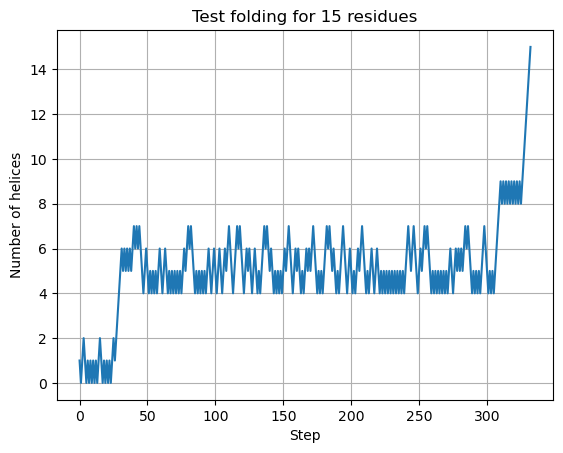

In [424]:
import matplotlib.pyplot as plt

plt.plot(macrostates)
plt.xlabel('Step')
plt.ylabel('Number of helices') 
plt.title('Test folding for 15 residues')
plt.grid()
plt.show()

In [425]:
generate_microstates(3)

{(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)}